In [3]:
from pathlib import Path

root = Path.cwd()
for p in [root, *root.parents]:
    if (p / "data" / "raw").exists():
        root = p
        break

raw = root / "data" / "raw"
assert raw.exists(), f"Cannot find {raw}. Your CWD is {Path.cwd()}"


def is_dataset_dir(p: Path) -> bool:
    return (
        (p/"train"/"cats").exists()
        and (p/"train"/"dogs").exists()
        and (p/"validation"/"cats").exists()
        and (p/"validation"/"dogs").exists()
    )

dirs = [p for p in raw.iterdir() if p.is_dir()]
DATA_DIR = next((p for p in dirs if is_dataset_dir(p)), None)

assert DATA_DIR is not None, f"No cats/dogs train+validation folder under {raw}. Found: {[d.name for d in dirs]}"

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "validation"

print("CWD =", Path.cwd())
print("ROOT =", root)
print("Using DATA_DIR =", DATA_DIR)
print("Train cats count dir exists:", (TRAIN_DIR/"cats").exists())

CWD = /Users/JW/Documents/mlzoomcamp/capstone2-cats-dogs
ROOT = /Users/JW/Documents/mlzoomcamp/capstone2-cats-dogs
Using DATA_DIR = /Users/JW/Documents/mlzoomcamp/capstone2-cats-dogs/data/raw/KK cats_and_dogs_filtered
Train cats count dir exists: True


In [4]:
from pathlib import Path

def count_images(dir_path: Path):
    exts = {".jpg", ".jpeg", ".png"}
    return len([p for p in dir_path.rglob("*") if p.suffix.lower() in exts])

for split_name, split_dir in [("train", TRAIN_DIR), ("validation", VAL_DIR)]:
    cats_n = count_images(split_dir / "cats")
    dogs_n = count_images(split_dir / "dogs")
    print(split_name, "cats=", cats_n, "dogs=", dogs_n, "total=", cats_n + dogs_n)

train cats= 250 dogs= 250 total= 500
validation cats= 63 dogs= 63 total= 126


In [5]:
from PIL import Image
import random

def find_bad_images(folder: Path, sample_size=1000, seed=42):
    exts = {".jpg", ".jpeg", ".png"}
    files = [p for p in folder.rglob("*") if p.suffix.lower() in exts]
    random.Random(seed).shuffle(files)
    files = files[: min(sample_size, len(files))]

    bad = []
    for p in files:
        try:
            with Image.open(p) as img:
                img.verify()  
        except Exception as e:
            bad.append((p, str(e)))
    return bad, len(files)

for name, folder in [("train/cats", TRAIN_DIR/"cats"),
                     ("train/dogs", TRAIN_DIR/"dogs"),
                     ("val/cats", VAL_DIR/"cats"),
                     ("val/dogs", VAL_DIR/"dogs")]:
    bad, checked = find_bad_images(folder, sample_size=1000)
    print(f"{name}: checked={checked}, bad={len(bad)}")
    if bad:
        print("  example bad:", bad[0][0], "|", bad[0][1])

train/cats: checked=250, bad=0
train/dogs: checked=250, bad=0
val/cats: checked=63, bad=0
val/dogs: checked=63, bad=0


All images are readable by PIL (no corrupted files found).

In [6]:
from pathlib import Path

def count_images(dir_path: Path):
    exts = {".jpg", ".jpeg", ".png"}
    return sum(1 for p in dir_path.rglob("*") if p.suffix.lower() in exts)

for name, folder in [("train/cats", TRAIN_DIR/"cats"),
                     ("train/dogs", TRAIN_DIR/"dogs"),
                     ("val/cats", VAL_DIR/"cats"),
                     ("val/dogs", VAL_DIR/"dogs")]:
    print(name, count_images(folder))

train/cats 250
train/dogs 250
val/cats 63
val/dogs 63


In [7]:
from pathlib import Path
from collections import Counter

def list_suffixes(folder: Path):
    return [p.suffix.lower() for p in folder.rglob("*") if p.is_file()]

for name, folder in [
    ("train/cats", TRAIN_DIR/"cats"),
    ("train/dogs", TRAIN_DIR/"dogs"),
    ("val/cats",   VAL_DIR/"cats"),
    ("val/dogs",   VAL_DIR/"dogs"),
]:
    c = Counter(list_suffixes(folder))
    print(name, c.most_common(5))

train/cats [('.jpg', 233), ('.jpeg', 17)]
train/dogs [('.jpg', 234), ('.jpeg', 16)]
val/cats [('.jpg', 59), ('.jpeg', 4)]
val/dogs [('.jpg', 62), ('.jpeg', 1)]


File integrity: all images are readable by PIL (no corrupted files found).
File types: only .jpg/.jpeg images are present in train/validation folders; no extraneous files.

In [12]:
from pathlib import Path
import shutil
import random

# ---------- 1) Paths: keep RAW and PROCESSED separate ----------
BASE_DIR = Path.cwd() 

RAW_DIR = BASE_DIR / "data" / "raw" / "KK_cats_and_dogs_filtered"
RAW_TRAIN_DIR = RAW_DIR / "train"
RAW_VAL_DIR   = RAW_DIR / "validation"

PROCESSED_DIR = BASE_DIR / "data" / "processed" / "cats_dogs_70_30"
OUT_TRAIN_DIR = PROCESSED_DIR / "train"
OUT_VAL_DIR   = PROCESSED_DIR / "validation"
OUT_TEST_DIR  = PROCESSED_DIR / "test"

IMG_EXTS = {".jpg", ".jpeg", ".png"}

# ---------- 2) Helpers ----------
def list_images(folder: Path):
    return [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in IMG_EXTS]

def safe_copy(src: Path, dst: Path):
    """
    Two safety guards:
    1) If src == dst -> skip (prevents SameFileError)
    2) If destination already exists -> skip (idempotent re-run)
    """
    dst.parent.mkdir(parents=True, exist_ok=True)

    # guard 1: same file
    if src.resolve() == dst.resolve():
        return False

    # guard 2: already copied
    if dst.exists():
        return False

    shutil.copy2(src, dst)
    return True

def prepare_dirs():
    for d in [
        OUT_TRAIN_DIR / "cats", OUT_TRAIN_DIR / "dogs",
        OUT_VAL_DIR / "cats",   OUT_VAL_DIR / "dogs",
        OUT_TEST_DIR / "cats",  OUT_TEST_DIR / "dogs",
    ]:
        d.mkdir(parents=True, exist_ok=True)

# ---------- 3) Copy all RAW train -> PROCESSED train ----------
def copy_all_train():
    for cls in ["cats", "dogs"]:
        src_dir = RAW_TRAIN_DIR / cls
        dst_dir = OUT_TRAIN_DIR / cls

        files = list_images(src_dir)
        copied = 0
        for p in files:
            if safe_copy(p, dst_dir / p.name):
                copied += 1

        print(f"[train/{cls}] total={len(files)}, copied_now={copied}, dst={dst_dir}")

# ---------- 4) Split RAW validation -> PROCESSED validation + test ----------
def split_val_to_val_test(val_ratio=0.70, seed=42):
    rng = random.Random(seed)

    for cls in ["cats", "dogs"]:
        src_dir = RAW_VAL_DIR / cls
        files = list_images(src_dir)
        rng.shuffle(files)

        n_total = len(files)
        n_val = int(n_total * val_ratio)
        val_files = files[:n_val]
        test_files = files[n_val:]

        copied_val = 0
        copied_test = 0

        for p in val_files:
            if safe_copy(p, (OUT_VAL_DIR / cls / p.name)):
                copied_val += 1

        for p in test_files:
            if safe_copy(p, (OUT_TEST_DIR / cls / p.name)):
                copied_test += 1

        print(f"[val split/{cls}] total={n_total} -> val={len(val_files)} (copied {copied_val}), "
              f"test={len(test_files)} (copied {copied_test})")

# ---------- 5) Run ----------
if __name__ == "__main__":
    # basic sanity checks
    assert RAW_TRAIN_DIR.exists(), RAW_TRAIN_DIR
    assert RAW_VAL_DIR.exists(), RAW_VAL_DIR

    prepare_dirs()
    copy_all_train()
    split_val_to_val_test(val_ratio=0.70, seed=42)

    print("\nUse this as your dataset root:", PROCESSED_DIR.resolve())

[train/cats] total=250, copied_now=0, dst=/Users/JW/Documents/mlzoomcamp/capstone2-cats-dogs/data/processed/cats_dogs_70_30/train/cats
[train/dogs] total=250, copied_now=0, dst=/Users/JW/Documents/mlzoomcamp/capstone2-cats-dogs/data/processed/cats_dogs_70_30/train/dogs
[val split/cats] total=63 -> val=44 (copied 14), test=19 (copied 14)
[val split/dogs] total=63 -> val=44 (copied 12), test=19 (copied 12)

Use this as your dataset root: /Users/JW/Documents/mlzoomcamp/capstone2-cats-dogs/data/processed/cats_dogs_70_30


In [9]:
from pathlib import Path

DATA_DIR = Path("data/processed/cats_dogs_70_30")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "validation"
TEST_DIR = DATA_DIR / "test"

In [13]:
from pathlib import Path

DATA_DIR = Path("data/processed/cats_dogs_70_30")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "validation"
TEST_DIR  = DATA_DIR / "test"

IMG_EXTS = {".jpg", ".jpeg", ".png"}

def count_images(folder: Path):
    return sum(1 for p in folder.rglob("*") if p.suffix.lower() in IMG_EXTS)

for split_name, split_dir in [("train", TRAIN_DIR), ("val", VAL_DIR), ("test", TEST_DIR)]:
    cats_n = count_images(split_dir / "cats")
    dogs_n = count_images(split_dir / "dogs")
    total = cats_n + dogs_n
    print(f"{split_name:5s}  cats={cats_n:4d}  dogs={dogs_n:4d}  total={total:4d}")

train  cats= 250  dogs= 250  total= 500
val    cats=  58  dogs=  56  total= 114
test   cats=  33  dogs=  31  total=  64


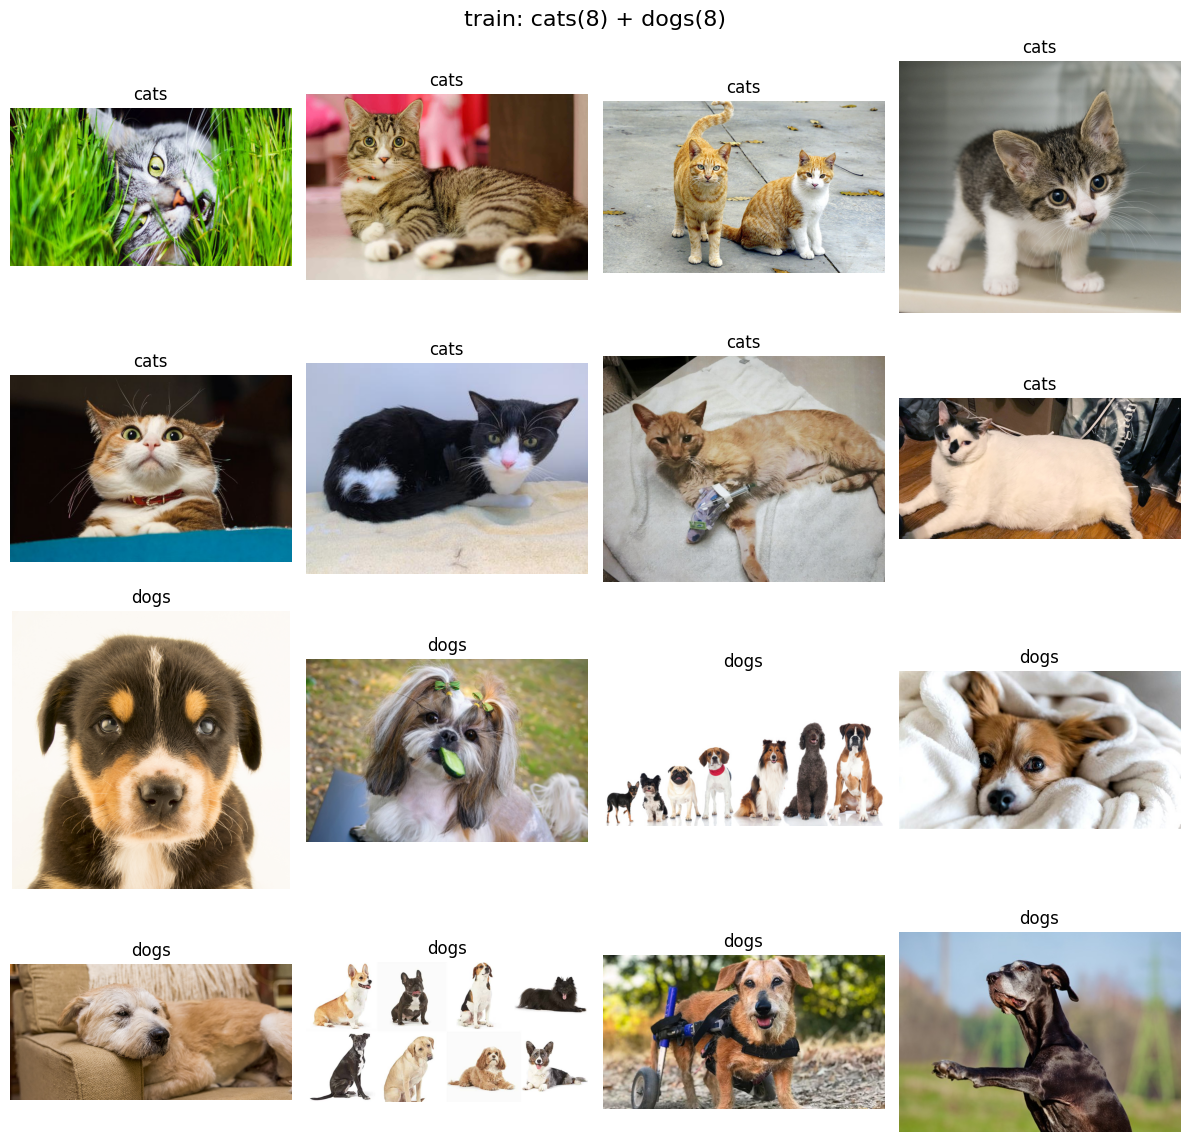

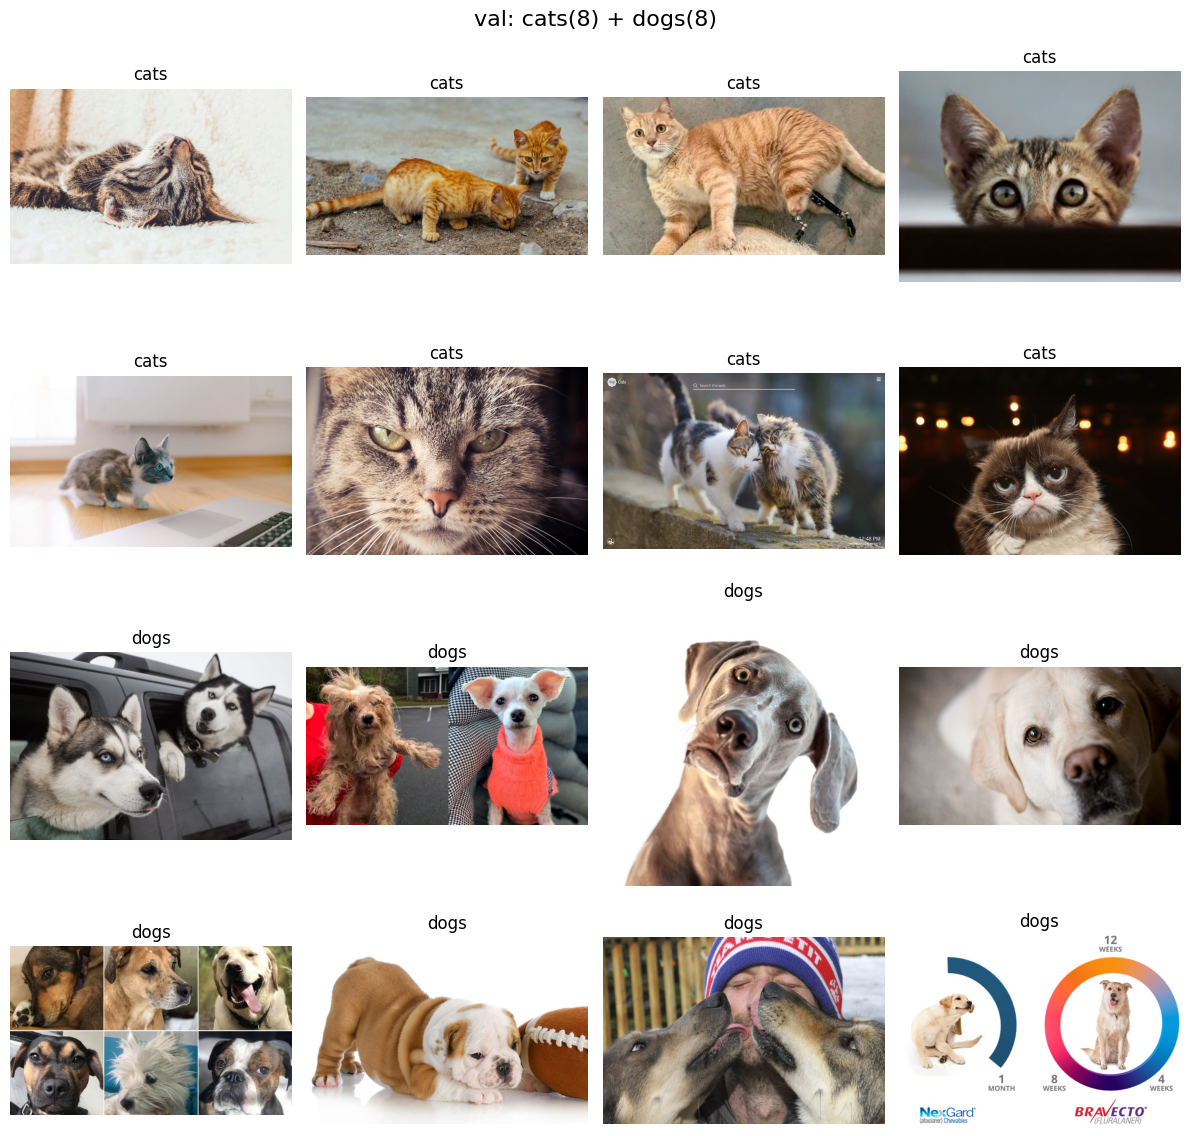

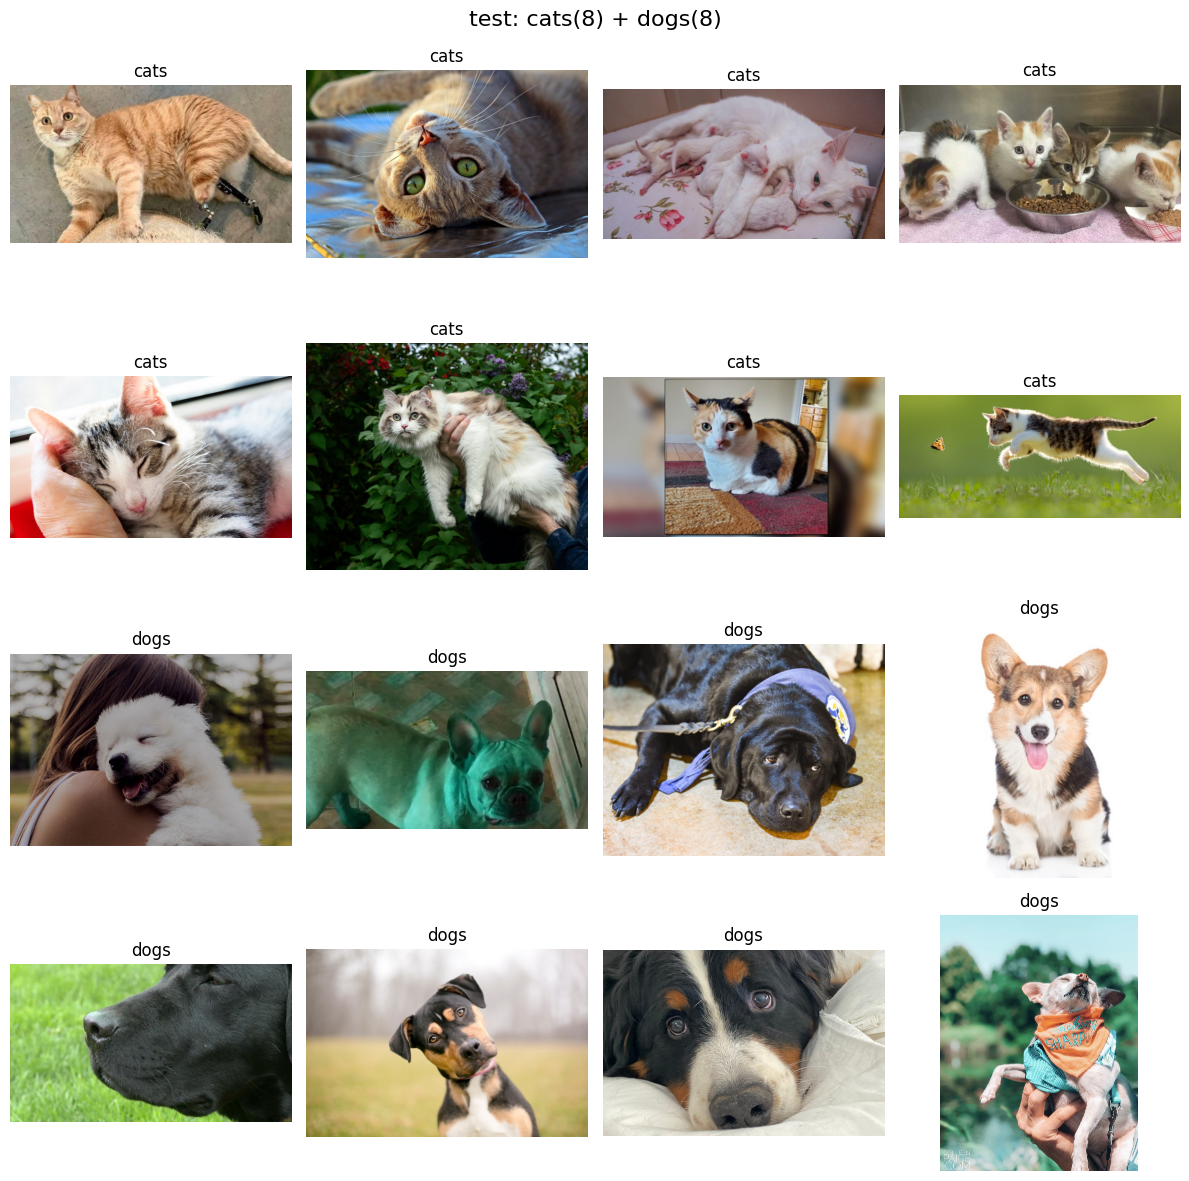

In [14]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def sample_images(folder: Path, n=8, seed=42):
    files = [p for p in folder.rglob("*") if p.suffix.lower() in IMG_EXTS]
    random.Random(seed).shuffle(files)
    return files[:n]

def show_grid(img_paths, title):
    cols = 4
    rows = (len(img_paths) + cols - 1) // cols
    plt.figure(figsize=(12, 3*rows))
    for i, p in enumerate(img_paths, 1):
        img = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.parent.name)  # cats/dogs
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

for split_name, split_dir in [("train", TRAIN_DIR), ("val", VAL_DIR), ("test", TEST_DIR)]:
    cats = sample_images(split_dir / "cats", n=8, seed=42)
    dogs = sample_images(split_dir / "dogs", n=8, seed=42)
    show_grid(cats + dogs, title=f"{split_name}: cats(8) + dogs(8)")

In [15]:
import pandas as pd
from PIL import Image

def collect_sizes(split_dir: Path, split_name: str, limit=None):
    rows = []
    for label in ["cats", "dogs"]:
        files = [p for p in (split_dir / label).rglob("*") if p.suffix.lower() in IMG_EXTS]
        if limit:
            files = files[:limit]
        for p in files:
            with Image.open(p) as im:
                w, h = im.size
            rows.append({"split": split_name, "label": label, "w": w, "h": h, "path": str(p)})
    return rows

rows = []
rows += collect_sizes(TRAIN_DIR, "train")
rows += collect_sizes(VAL_DIR, "val")
rows += collect_sizes(TEST_DIR, "test")

df_sizes = pd.DataFrame(rows)
df_sizes["aspect_ratio"] = df_sizes["w"] / df_sizes["h"]
df_sizes.head()

split label     w     h                                               path  \
0  train  cats  1000   667  data/processed/cats_dogs_70_30/train/cats/Cat_...   
1  train  cats   728   546  data/processed/cats_dogs_70_30/train/cats/Cat_...   
2  train  cats   728   486  data/processed/cats_dogs_70_30/train/cats/Cat_...   
3  train  cats  5158  3373  data/processed/cats_dogs_70_30/train/cats/Cat_...   
4  train  cats  1733  1300  data/processed/cats_dogs_70_30/train/cats/Cat_...   

   aspect_ratio  
0      1.499250  
1      1.333333  
2      1.497942  
3      1.529202  
4      1.333077

In [16]:
summary = (
    df_sizes
    .groupby(["split", "label"])
    .agg(
        n=("path", "count"),
        w_min=("w", "min"),
        w_med=("w", "median"),
        w_max=("w", "max"),
        h_min=("h", "min"),
        h_med=("h", "median"),
        h_max=("h", "max"),
        ar_med=("aspect_ratio", "median"),
    )
    .reset_index()
)

summary

split label    n  w_min   w_med  w_max  h_min  h_med  h_max    ar_med
0   test  cats   33    410   960.0   5571    230  630.0   3719  1.599500
1   test  dogs   31    261   710.0   4115    149  473.0   5319  1.501272
2  train  cats  250    300  1000.0   6720    222  629.0   4480  1.500237
3  train  dogs  250    180   909.5   5184    149  575.0   4312  1.501356
4    val  cats   58    400   985.0   5571    230  686.5   3719  1.500769
5    val  dogs   56    261   849.0   4032    225  598.5   3024  1.500960

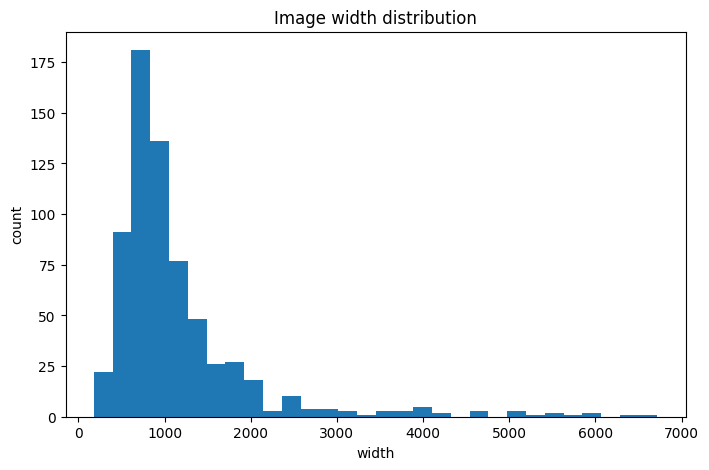

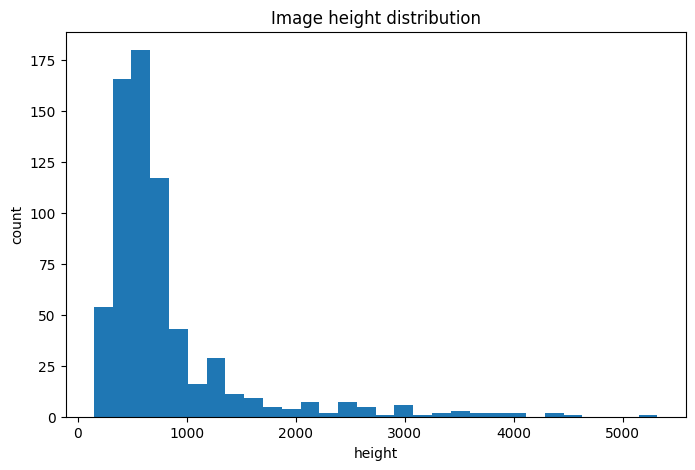

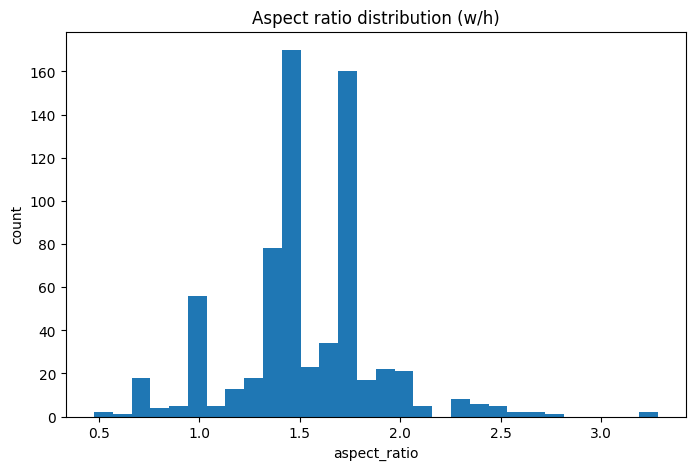

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_sizes["w"], bins=30)
plt.title("Image width distribution")
plt.xlabel("width")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df_sizes["h"], bins=30)
plt.title("Image height distribution")
plt.xlabel("height")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df_sizes["aspect_ratio"], bins=30)
plt.title("Aspect ratio distribution (w/h)")
plt.xlabel("aspect_ratio")
plt.ylabel("count")
plt.show()

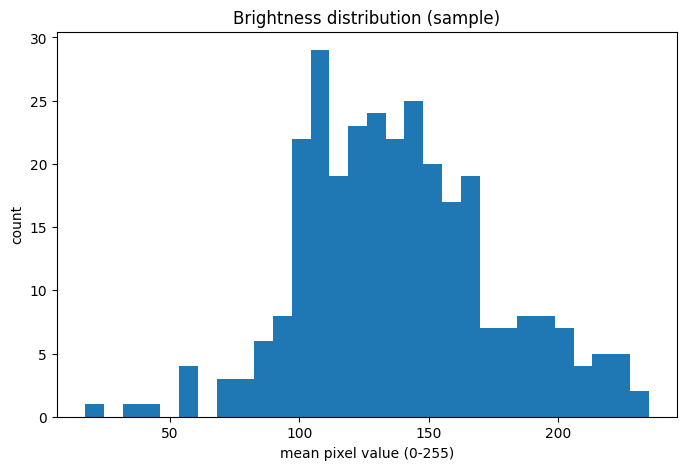

In [18]:
import numpy as np

def mean_brightness(path: str):
    img = Image.open(path).convert("L")  # grayscale
    arr = np.array(img)
    return arr.mean()


sample_df = df_sizes.sample(min(300, len(df_sizes)), random_state=42).copy()
sample_df["brightness"] = sample_df["path"].apply(mean_brightness)

plt.figure(figsize=(8,5))
plt.hist(sample_df["brightness"], bins=30)
plt.title("Brightness distribution (sample)")
plt.xlabel("mean pixel value (0-255)")
plt.ylabel("count")
plt.show()

EDA Summary (Cats vs Dogs)
	•	Dataset size & balance:
Train = 500 images (250 cats / 250 dogs).
Validation = 114 images (58 cats / 56 dogs).
Test = 64 images (33 cats / 31 dogs).
Overall, the dataset is nearly balanced across splits.
	•	Image resolution variability:
The dataset contains highly variable image sizes. Width and height distributions are right-skewed with a few very large images (up to several thousand pixels).
This suggests we should resize images to a fixed input size (e.g., 224×224) for training.
	•	Aspect ratio distribution:
Most images have aspect ratio around ~1.4–1.8, but there are outliers (very wide/tall images).
Using Resize + CenterCrop (or padding) can help reduce distortion.
	•	Brightness (sample):
Mean pixel brightness spans a wide range (roughly from darker images to very bright ones), indicating different lighting conditions.
Data augmentation (random brightness/contrast) can improve robustness.
	•	Data quality checks:
Random sampling with PIL verification found no corrupted images in the checked subset.

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

DATA_DIR = "data/processed/cats_dogs_70_30"


tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


train_ds = datasets.ImageFolder(f"{DATA_DIR}/train", transform=tfm)
val_ds   = datasets.ImageFolder(f"{DATA_DIR}/validation", transform=tfm)
test_ds  = datasets.ImageFolder(f"{DATA_DIR}/test", transform=tfm)


print(train_ds.class_to_idx)   # 例如 {'cats': 0, 'dogs': 1}
print(len(train_ds), len(val_ds), len(test_ds))


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

{'cats': 0, 'dogs': 1}
500 114 64


In [20]:
import sys
print(sys.executable)

/Users/JW/Documents/mlzoomcamp/capstone2-cats-dogs/.venv/bin/python


In [1]:
import sys
print(sys.executable)

/Users/JW/Documents/mlzoomcamp/capstone2-cats-dogs/.venv/bin/python


In [2]:
import torch
import torchvision
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

torch: 2.10.0
torchvision: 0.25.0


In [3]:
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

DATA_DIR = Path("data/processed/cats_dogs_70_30")

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

eval_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(DATA_DIR / "train", transform=train_tf)
val_ds   = datasets.ImageFolder(DATA_DIR / "validation", transform=eval_tf)
test_ds  = datasets.ImageFolder(DATA_DIR / "test", transform=eval_tf)

print("classes:", train_ds.classes)
print("sizes:", len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

classes: ['cats', 'dogs']
sizes: 500 114 64


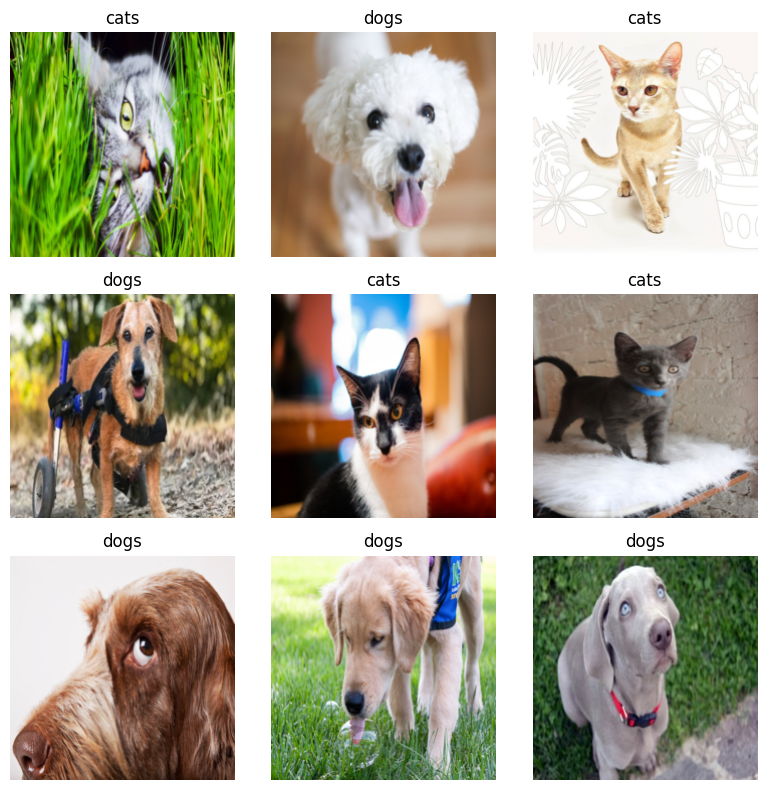

In [4]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = images[i].permute(1, 2, 0)  # CHW -> HWC
    plt.imshow(img)
    plt.title(train_ds.classes[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)


model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(model, loader, train=True):
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.set_grad_enabled(train):
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            if train:
                optimizer.zero_grad()

            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)

    return total_loss / total, correct / total


for epoch in range(1, 4):
    train_loss, train_acc = run_epoch(model, train_loader, train=True)
    val_loss, val_acc = run_epoch(model, val_loader, train=False)
    print(f"epoch {epoch}: train loss={train_loss:.4f} acc={train_acc:.3f} | val loss={val_loss:.4f} acc={val_acc:.3f}")

device: mps
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/JW/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 51.4MB/s]


epoch 1: train loss=0.4466 acc=0.850 | val loss=2.7211 acc=0.789
epoch 2: train loss=0.3152 acc=0.840 | val loss=0.1995 acc=0.921
epoch 3: train loss=0.1276 acc=0.962 | val loss=0.2719 acc=0.895


In [8]:
import torch
from pathlib import Path
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


DATA_DIR = Path("data/processed/cats_dogs_70_30")
TEST_DIR = DATA_DIR / "test"


classes = sorted([p.name for p in TEST_DIR.iterdir() if p.is_dir() and not p.name.startswith(".")])
assert len(classes) > 0, f"No class folders found under: {TEST_DIR.resolve()}"
print("classes:", classes)


model.eval()

test_loss_sum = 0.0
test_correct = 0
test_total = 0

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        test_loss_sum += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)

        test_correct += (preds == yb).sum().item()
        test_total += xb.size(0)

        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

test_loss = test_loss_sum / max(1, test_total)
test_acc = test_correct / max(1, test_total)

print(f"TEST loss={test_loss:.4f} acc={test_acc:.4f}")


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

classes: ['cats', 'dogs']
TEST loss=0.3427 acc=0.8125
Confusion matrix:
 [[24  9]
 [ 3 28]]
Classification report:
              precision    recall  f1-score   support

        cats     0.8889    0.7273    0.8000        33
        dogs     0.7568    0.9032    0.8235        31

    accuracy                         0.8125        64
   macro avg     0.8228    0.8152    0.8118        64
weighted avg     0.8249    0.8125    0.8114        64



In [11]:

from pathlib import Path
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

DATA_DIR = Path("data/processed/cats_dogs_70_30")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "validation"
TEST_DIR  = DATA_DIR / "test"

assert TRAIN_DIR.exists(), TRAIN_DIR
assert VAL_DIR.exists(), VAL_DIR
assert TEST_DIR.exists(), TEST_DIR


# =========================
# 1) Transforms + datasets + loaders
# =========================
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=eval_tfms)

classes = train_ds.classes
print("classes:", classes)
print("说明: ImageFolder 会按文件夹名排序给类别编码，比如 cats->0, dogs->1")
print("class_to_idx:", train_ds.class_to_idx)
print("sizes:", len(train_ds), len(val_ds), len(test_ds))

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# =========================
# 2) Model: MobileNetV3-small (pretrained) + replace head (2 classes)
# =========================
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, len(classes))  # 2 classes

model = model.to(device)
print(model.__class__.__name__, "ready. head out:", len(classes))


# =========================
# 3) Train / Eval loops
# =========================
def run_epoch(model, loader, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    total_loss, correct, total = 0.0, 0, 0

    with torch.set_grad_enabled(train_mode):
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = F.cross_entropy(logits, y)

            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)

    return total_loss / total, correct / total


# =========================
# 4) Train (you can change lr/weight_decay to do tuning)
# =========================
lr = 3e-4
weight_decay = 1e-4
epochs = 3

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer)
    val_loss, val_acc     = run_epoch(model, val_loader, optimizer=None)
    print(f"epoch {epoch}: train loss={train_loss:.4f} acc={train_acc:.3f} | val loss={val_loss:.4f} acc={val_acc:.3f}")


# =========================
# 5) Test evaluation + confusion matrix + report
# =========================
model.eval()
y_true, y_pred = [], []
test_loss_sum, total = 0.0, 0
correct = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        test_loss_sum += loss.item() * x.size(0)
        total += x.size(0)

        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()

        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())

test_loss = test_loss_sum / total
test_acc = correct / total

print(f"\nTEST loss={test_loss:.4f} acc={test_acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

device: mps
classes: ['cats', 'dogs']
说明: ImageFolder 会按文件夹名排序给类别编码，比如 cats->0, dogs->1
class_to_idx: {'cats': 0, 'dogs': 1}
sizes: 500 114 64
MobileNetV3 ready. head out: 2
epoch 1: train loss=0.4087 acc=0.810 | val loss=0.2995 acc=0.851
epoch 2: train loss=0.1211 acc=0.970 | val loss=0.3500 acc=0.868
epoch 3: train loss=0.0567 acc=0.984 | val loss=0.2002 acc=0.912

TEST loss=0.2707 acc=0.8750
Confusion matrix:
 [[25  8]
 [ 0 31]]

Classification report:
              precision    recall  f1-score   support

        cats     1.0000    0.7576    0.8621        33
        dogs     0.7949    1.0000    0.8857        31

    accuracy                         0.8750        64
   macro avg     0.8974    0.8788    0.8739        64
weighted avg     0.9006    0.8750    0.8735        64



Conclusion (MobileNetV3-small)

We fine-tuned an ImageNet-pretrained MobileNetV3-small for the cats vs dogs binary classification task by replacing the final classification head (2 classes) and applying light data augmentation. Training for 3 epochs achieved the following results:
	•	Epoch 1: train loss 0.4087, train acc 0.810 | val loss 0.2995, val acc 0.851
	•	Epoch 2: train loss 0.1211, train acc 0.970 | val loss 0.3500, val acc 0.868
	•	Epoch 3: train loss 0.0567, train acc 0.984 | val loss 0.2002, val acc 0.912

On the test set, the model achieved Accuracy = 0.8750 with Loss = 0.2707. The confusion matrix was [[25, 8], [0, 31]], indicating perfect dog recall (1.0000) and that most errors came from cats misclassified as dogs. The classification report shows:
	•	Cats: precision 1.0000, recall 0.7576, F1 0.8621 (support=33)
	•	Dogs: precision 0.7949, recall 1.0000, F1 0.8857 (support=31)
	•	Macro F1: 0.8739, Weighted F1: 0.8735

Overall, the model is conservative about predicting “cat” (high cat precision) but misses some cat images (lower cat recall). Further tuning (e.g., learning rate/weight decay sweep, adjusting augmentation strength, or class weighting) can help improve cat recall while maintaining overall performance.

In [12]:
import copy
import time
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# 0) settings
# ----------------------------
LRS = [1e-4, 3e-4, 1e-3]
EPOCHS = 5
WEIGHT_DECAY = 1e-4

# 如果你已经定义过 classes，就保留；否则用这个（ImageFolder 默认 cats=0 dogs=1）
classes = ["cats", "dogs"]

# ----------------------------
# 1) helpers
# ----------------------------
def build_mobilenetv3_small(device):
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, 2)
    return model.to(device)

@torch.no_grad()
def eval_one_epoch(model, loader, device, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total

def train_one_epoch(model, loader, device, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().tolist()
        y_pred.extend(pred)
        y_true.extend(y.tolist())
    return y_true, y_pred

def extract_recalls_from_report(report_dict):
    # report_dict['cats']['recall'] and report_dict['dogs']['recall']
    cats_recall = report_dict.get("cats", {}).get("recall", None)
    dogs_recall = report_dict.get("dogs", {}).get("recall", None)
    return cats_recall, dogs_recall

# ----------------------------
# 2) sweep
# ----------------------------
results = []

for lr in LRS:
    print("\n" + "="*60)
    print(f"LR = {lr} | epochs={EPOCHS} | weight_decay={WEIGHT_DECAY}")
    print("="*60)

    model = build_mobilenetv3_small(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    best_val_acc = -1
    best_val_loss = float("inf")
    best_state = None

    start = time.time()
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, device, optimizer, criterion)
        val_loss, val_acc = eval_one_epoch(model, val_loader, device, criterion)

        print(f"epoch {epoch}: "
              f"train loss={train_loss:.4f} acc={train_acc:.3f} | "
              f"val loss={val_loss:.4f} acc={val_acc:.3f}")

        # 以 val_acc 为主，val_loss 做次要 tie-break
        if (val_acc > best_val_acc) or (val_acc == best_val_acc and val_loss < best_val_loss):
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_state = copy.deepcopy(model.state_dict())

    elapsed = time.time() - start
    print(f"Done. best val acc={best_val_acc:.4f}, best val loss={best_val_loss:.4f}, time={elapsed:.1f}s")

    # load best
    model.load_state_dict(best_state)

    # test metrics
    test_loss, test_acc = eval_one_epoch(model, test_loader, device, criterion)
    y_true, y_pred = predict_all(model, test_loader, device)
    cm = confusion_matrix(y_true, y_pred)
    rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    cats_recall, dogs_recall = extract_recalls_from_report(rep)

    print("\nTEST:")
    print(f"loss={test_loss:.4f} acc={test_acc:.4f}")
    print("Confusion matrix:\n", cm)
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

    results.append({
        "lr": lr,
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "test_acc": test_acc,
        "test_loss": test_loss,
        "cats_recall": cats_recall,
        "dogs_recall": dogs_recall,
        "cm": cm,
    })

# sort summary
print("\n" + "#"*60)
print("SWEEP SUMMARY (sorted by best_val_acc desc)")
print("#"*60)
results_sorted = sorted(results, key=lambda d: (d["best_val_acc"], -d["best_val_loss"]), reverse=True)
for r in results_sorted:
    print(f"lr={r['lr']:<8} best_val_acc={r['best_val_acc']:.4f} "
          f"best_val_loss={r['best_val_loss']:.4f} test_acc={r['test_acc']:.4f} "
          f"cats_recall={r['cats_recall']:.4f} dogs_recall={r['dogs_recall']:.4f}")


LR = 0.0001 | epochs=5 | weight_decay=0.0001
epoch 1: train loss=0.5728 acc=0.746 | val loss=0.3545 acc=0.921
epoch 2: train loss=0.3560 acc=0.904 | val loss=0.2298 acc=0.939
epoch 3: train loss=0.2191 acc=0.952 | val loss=0.1934 acc=0.939
epoch 4: train loss=0.1529 acc=0.964 | val loss=0.2186 acc=0.921
epoch 5: train loss=0.1115 acc=0.962 | val loss=0.1941 acc=0.930
Done. best val acc=0.9386, best val loss=0.1934, time=56.9s

TEST:
loss=0.2307 acc=0.9219
Confusion matrix:
 [[28  5]
 [ 0 31]]
Classification report:
              precision    recall  f1-score   support

        cats     1.0000    0.8485    0.9180        33
        dogs     0.8611    1.0000    0.9254        31

    accuracy                         0.9219        64
   macro avg     0.9306    0.9242    0.9217        64
weighted avg     0.9327    0.9219    0.9216        64


LR = 0.0003 | epochs=5 | weight_decay=0.0001
epoch 1: train loss=0.4418 acc=0.796 | val loss=0.3813 acc=0.798
epoch 2: train loss=0.1324 acc=0.958 | v

Tuning results (LR sweep)
	•	lr = 3e-4: best_val_acc = 0.9561, best_val_loss = 0.1092, test_acc = 0.9844, cats_recall = 0.9697, dogs_recall = 1.0000 ✅ (best overall)
	•	lr = 1e-3: test_acc = 0.9375, with dogs_recall dropping to 0.9355 (too aggressive)
	•	lr = 1e-4: test_acc = 0.9219, with cats_recall = 0.8485 (too conservative)

In [36]:
import os
import time
import copy
import random
import numpy as np

import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report


# -----------------------
# 0) Reproducibility
# -----------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # (CUDA not used on Mac, but harmless)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # MPS seed
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)


# -----------------------
# 1) Model builder
# -----------------------
def build_mobilenetv3_small(num_classes: int = 2):
    model = models.mobilenet_v3_small(
        weights=models.MobileNet_V3_Small_Weights.DEFAULT
    )
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model


# -----------------------
# 2) Train / Eval loops
# -----------------------
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    y_true, y_pred = [], []

    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()

        y_pred.extend(pred)
        y_true.extend(y.cpu().numpy().tolist())

    return np.array(y_true), np.array(y_pred)


# -----------------------
# 3) One experiment
#   - choose best by val_loss (minimize)
#   - early stopping on val_loss
#   - save best weights
# -----------------------
def run_experiment(
    learning_rate: float = 3e-4,
    weight_decay: float = 1e-4,
    epochs: int = 15,
    seed: int = 42,
    classes=("cats", "dogs"),
    early_stop_patience: int = 3,
    min_delta: float = 0.0,
    save_dir: str = "models",
):
    set_seed(seed)

    model = build_mobilenetv3_small(num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    best_state = None
    best_val_loss = float("inf")
    best_val_acc = -1.0
    best_epoch = None

    no_improve = 0
    t0 = time.time()

    print("\n" + "=" * 60)
    print(
        f"RUN: lr={learning_rate} | wd={weight_decay} | epochs={epochs} | seed={seed}"
    )
    print("=" * 60)

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        improved = val_loss < (best_val_loss - min_delta)
        if improved:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1

        print(
            f"epoch {epoch:02d}: "
            f"train loss={train_loss:.4f} acc={train_acc:.3f} | "
            f"val loss={val_loss:.4f} acc={val_acc:.3f} | "
            f"best_val_loss={best_val_loss:.4f} (epoch={best_epoch}) | "
            f"no_improve={no_improve}/{early_stop_patience}"
        )

        if no_improve >= early_stop_patience:
            print(
                f"EARLY STOP at epoch {epoch}. "
                f"Best epoch={best_epoch} (best_val_loss={best_val_loss:.4f})."
            )
            break

    # ---- load best weights ----
    if best_state is not None:
        model.load_state_dict(best_state)

    # ---- save best weights ----
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(
        save_dir,
        f"mobilenetv3_lr{learning_rate}_wd{weight_decay}_seed{seed}.pt"
    )
    torch.save(model.state_dict(), save_path)

    # ---- test ----
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    y_true, y_pred = predict_all(model, test_loader)
    cm = confusion_matrix(y_true, y_pred)

    report = classification_report(
        y_true,
        y_pred,
        target_names=list(classes),
        digits=4,
        output_dict=True,
    )
    cats_recall = report[classes[0]]["recall"]
    dogs_recall = report[classes[1]]["recall"]

    elapsed = time.time() - t0

    print("---- SUMMARY ----")
    print(
        f"seed={seed} lr={learning_rate} wd={weight_decay} "
        f"best_epoch={best_epoch} best_val_loss={best_val_loss:.4f} best_val_acc={best_val_acc:.4f} "
        f"test_acc={test_acc:.4f} test_loss={test_loss:.4f} "
        f"cats_recall={cats_recall:.4f} dogs_recall={dogs_recall:.4f} "
        f"time={elapsed:.1f}s | saved={save_path}"
    )
    print("Confusion matrix:\n", cm)

    return {
        "seed": seed,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "epochs_requested": epochs,
        "early_stop_patience": early_stop_patience,
        "min_delta": min_delta,
        "best_epoch": best_epoch,
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "test_acc": test_acc,
        "test_loss": test_loss,
        "cats_recall": cats_recall,
        "dogs_recall": dogs_recall,
        "confusion_matrix": cm,
        "time_sec": elapsed,
        "save_path": save_path,
    }


# -----------------------
# 4) Re-run with different seeds (fixed settings)
# -----------------------
learning_rate = 3e-4
weight_decay = 1e-4
epochs = 15
seeds = [1, 2, 3]

results = []
for seed in seeds:
    res = run_experiment(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        epochs=epochs,
        seed=seed,
        classes=("cats", "dogs"),
        early_stop_patience=3,
        min_delta=0.0,
        save_dir="models",
    )
    results.append(res)

print("\nSUMMARY (per seed):")
for r in results:
    print(
        f"seed={r['seed']} | "
        f"best_epoch={r['best_epoch']} | "
        f"test_acc={r['test_acc']:.4f} | "
        f"cats_recall={r['cats_recall']:.4f} | "
        f"dogs_recall={r['dogs_recall']:.4f} | "
        f"best_val_loss={r['best_val_loss']:.4f} | "
        f"best_val_acc={r['best_val_acc']:.4f} | "
        f"time={r['time_sec']:.1f}s"
    )

device: mps

RUN: lr=0.0003 | wd=0.0001 | epochs=15 | seed=1
epoch 01: train loss=0.4181 acc=0.810 | val loss=0.1431 acc=0.939 | best_val_loss=0.1431 (epoch=1) | no_improve=0/3
epoch 02: train loss=0.1420 acc=0.948 | val loss=0.4292 acc=0.868 | best_val_loss=0.1431 (epoch=1) | no_improve=1/3
epoch 03: train loss=0.0559 acc=0.988 | val loss=0.1815 acc=0.921 | best_val_loss=0.1431 (epoch=1) | no_improve=2/3
epoch 04: train loss=0.0257 acc=0.998 | val loss=0.2022 acc=0.921 | best_val_loss=0.1431 (epoch=1) | no_improve=3/3
EARLY STOP at epoch 4. Best epoch=1 (best_val_loss=0.1431).
---- SUMMARY ----
seed=1 lr=0.0003 wd=0.0001 best_epoch=1 best_val_loss=0.1431 best_val_acc=0.9386 test_acc=0.9375 test_loss=0.1564 cats_recall=0.9091 dogs_recall=0.9677 time=46.9s | saved=models/mobilenetv3_lr0.0003_wd0.0001_seed1.pt
Confusion matrix:
 [[30  3]
 [ 1 30]]

RUN: lr=0.0003 | wd=0.0001 | epochs=15 | seed=2
epoch 01: train loss=0.4255 acc=0.826 | val loss=0.2574 acc=0.895 | best_val_loss=0.2574 (epo

This project trained an image classifier for cats vs dogs using pretrained MobileNetV3-small. With AdamW (lr=3e-4, weight_decay=1e-4) and early stopping, the model achieved strong performance on the test set. Across 3 random seeds, test accuracy ranged from 0.9375 to 0.9844, with the best run reaching 0.9844 (cats recall 0.9697, dogs recall 1.0000). Results may vary slightly due to the small test set.

In [33]:
# ============== TRAIN LOOP (simple & correct) ==============
epochs = 15
early_stopper = EarlyStopping(patience=5, min_delta=0.005)

print("train batches:", len(train_loader))
print("val   batches:", len(val_loader))
assert len(train_loader) > 0, "train_loader is empty"
assert len(val_loader) > 0, "val_loader is empty"

for epoch in range(1, epochs + 1):
    # 1) train for 1 epoch
    train_loss, train_acc = run_one_epoch_train(
        model=model,
        loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
    )

    # 2) evaluate on val
    val_loss, val_acc = run_one_epoch_eval(
        model=model,
        loader=val_loader,
        criterion=criterion,
        device=device,
    )

    # 3) update early stopper (IMPORTANT: do this BEFORE printing)
    should_stop = early_stopper.step(val_loss=val_loss, model=model, epoch=epoch)

    # 4) print (now best_loss/best_epoch/counter are the UPDATED values)
    print(
        f"epoch {epoch:02d}: "
        f"train loss={train_loss:.4f} acc={train_acc:.3f} | "
        f"val loss={val_loss:.4f} acc={val_acc:.3f} | "
        f"best_val_loss={early_stopper.best_loss:.4f} "
        f"best_epoch={early_stopper.best_epoch} "
        f"no_improve={early_stopper.counter}/{early_stopper.patience}"
    )

    if should_stop:
        print(
            f"EARLY STOP at epoch {epoch}. "
            f"Best epoch={early_stopper.best_epoch} (best_val_loss={early_stopper.best_loss:.4f})."
        )
        break

# restore best weights before test
early_stopper.restore_best(model)
print(
    f"Restored best model from epoch {early_stopper.best_epoch} "
    f"(best_val_loss={early_stopper.best_loss:.4f})."
)

train batches: 16
val   batches: 4
epoch 01: train loss=0.0387 acc=0.992 | val loss=0.0638 acc=0.956 | best_val_loss=0.0638 best_epoch=1 no_improve=0/5
epoch 02: train loss=0.0222 acc=0.996 | val loss=0.1823 acc=0.939 | best_val_loss=0.0638 best_epoch=1 no_improve=1/5
epoch 03: train loss=0.0178 acc=0.992 | val loss=0.2831 acc=0.930 | best_val_loss=0.0638 best_epoch=1 no_improve=2/5
epoch 04: train loss=0.0237 acc=0.994 | val loss=0.6066 acc=0.895 | best_val_loss=0.0638 best_epoch=1 no_improve=3/5
epoch 05: train loss=0.0132 acc=0.998 | val loss=0.9262 acc=0.886 | best_val_loss=0.0638 best_epoch=1 no_improve=4/5
epoch 06: train loss=0.0320 acc=0.982 | val loss=0.2770 acc=0.930 | best_val_loss=0.0638 best_epoch=1 no_improve=5/5
EARLY STOP at epoch 6. Best epoch=1 (best_val_loss=0.0638).
Restored best model from epoch 1 (best_val_loss=0.0638).


In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


from pathlib import Path
DATA_DIR = Path("data/processed/cats_dogs_70_30")
TEST_DIR = DATA_DIR / "test"
classes = sorted([p.name for p in TEST_DIR.iterdir() if p.is_dir() and not p.name.startswith(".")])
print("classes:", classes)

@torch.no_grad()
def evaluate_on_test(model, loader, criterion, device):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    y_true_all, y_pred_all = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)

        correct += (pred == y).sum().item()
        total += y.size(0)

        y_true_all.extend(y.cpu().numpy().tolist())
        y_pred_all.extend(pred.cpu().numpy().tolist())

    test_loss = loss_sum / total
    test_acc = correct / total
    return test_loss, test_acc, np.array(y_true_all), np.array(y_pred_all)

test_loss, test_acc, y_true, y_pred = evaluate_on_test(model, test_loader, criterion, device)

print(f"TEST: loss={test_loss:.4f} acc={test_acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

classes: ['cats', 'dogs']
TEST: loss=0.2611 acc=0.9531
Confusion matrix:
 [[30  3]
 [ 0 31]]
Classification report:
              precision    recall  f1-score   support

        cats     1.0000    0.9091    0.9524        33
        dogs     0.9118    1.0000    0.9538        31

    accuracy                         0.9531        64
   macro avg     0.9559    0.9545    0.9531        64
weighted avg     0.9573    0.9531    0.9531        64



In [27]:
print("\n===== RUN CONFIG =====")
print("device:", device)

# training control
print("epochs:", epochs)
print("early_stopping: patience =", early_stopper.patience, "| min_delta =", early_stopper.min_delta)

# dataloaders
print("batch_size (train):", train_loader.batch_size)
print("batch_size (val):", val_loader.batch_size)
print("batch_size (test):", test_loader.batch_size)

# optimizer hyperparams
opt = optimizer
print("optimizer:", type(opt).__name__)
print("lr:", opt.param_groups[0]["lr"])
print("weight_decay:", opt.param_groups[0].get("weight_decay", None))

# transforms / augmentation
print("\ntrain_transforms:")
print(train_tfms)
print("\neval_transforms:")
print(eval_tfms)
print("===== END CONFIG =====\n")


===== RUN CONFIG =====
device: mps
epochs: 15
early_stopping: patience = 5 | min_delta = 0.005
batch_size (train): 32
batch_size (val): 32
batch_size (test): 32
optimizer: AdamW
lr: 0.001
weight_decay: 0.0001

train_transforms:
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

eval_transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
===== END CONFIG =====



In [35]:
print("has run_experiment:", "run_experiment" in globals())
print("has results:", "results" in globals())
if "results" in globals():
    print("results len:", len(results))

has run_experiment: True
has results: True
results len: 3


In [37]:
from pathlib import Path
import json

metric = "test_acc"
maximize = True

def pick_best_from_results(results, metric="test_acc", maximize=True):
    if not results:
        raise ValueError("results is empty")

    missing = [i for i, r in enumerate(results) if metric not in r]
    if missing:
        raise KeyError(f"Some entries missing metric='{metric}', indices={missing[:10]}")

    best = max(results, key=lambda r: r[metric]) if maximize else min(results, key=lambda r: r[metric])
    return best


best = None
source = None

if "results" in globals() and isinstance(results, list) and len(results) > 0:
    best = pick_best_from_results(results, metric=metric, maximize=maximize)
    source = "notebook variable: results"


if best is None:
    p = Path("models/results_summary.json")
    if not p.exists():
        raise FileNotFoundError("No `results` in notebook and models/results_summary.json not found.")
    data = json.loads(p.read_text(encoding="utf-8"))

    runs = data.get("runs") if isinstance(data, dict) else data
    if not isinstance(runs, list) or len(runs) == 0:
        raise ValueError("results_summary.json doesn't contain a non-empty list of runs.")
    best = pick_best_from_results(runs, metric=metric, maximize=maximize)
    source = "file: models/results_summary.json"

seed = best.get("seed", None)
lr = best.get("learning_rate", None) or best.get("lr", None)
wd = best.get("weight_decay", None) or best.get("wd", None)


guessed_path = None
if seed is not None and lr is not None and wd is not None:
    guessed_path = f"models/mobilenetv3_lr{lr}_wd{wd}_seed{seed}.pt"

print(f"[source] {source}")
print(f"[selection] metric='{metric}', maximize={maximize}")
print(f"[best] seed={seed} | {metric}={best.get(metric)}")
print("[best full record]")
print(best)

if guessed_path:
    print(f"\n[guessed weights path]\n{guessed_path}")
    print("\nIf this file exists, you can fix it as deployment model by:")
    print(f"cp {guessed_path} models/model.pt")

[source] notebook variable: results
[selection] metric='test_acc', maximize=True
[best] seed=3 | test_acc=0.984375
[best full record]
{'seed': 3, 'learning_rate': 0.0003, 'weight_decay': 0.0001, 'epochs_requested': 15, 'early_stop_patience': 3, 'min_delta': 0.0, 'best_epoch': 5, 'best_val_acc': 0.9736842105263158, 'best_val_loss': 0.10925340064262089, 'test_acc': 0.984375, 'test_loss': 0.0906396172940731, 'cats_recall': 0.9696969696969697, 'dogs_recall': 1.0, 'confusion_matrix': array([[32,  1],
       [ 0, 31]]), 'time_sec': 86.18535995483398, 'save_path': 'models/mobilenetv3_lr0.0003_wd0.0001_seed3.pt'}

[guessed weights path]
models/mobilenetv3_lr0.0003_wd0.0001_seed3.pt

If this file exists, you can fix it as deployment model by:
cp models/mobilenetv3_lr0.0003_wd0.0001_seed3.pt models/model.pt
